In [1]:
## Demarrage du projet ##
1+1 #Ca porte chance

2

In [1]:
from Data import DataLoader
from Data import RadarDataSet
from PreProcessing.domaines.passage_freq import get_signal_frequentiel
from Models.PolynomialRegressor import PolynomialRegressor
from Models.BasicNNModel import BasicNNModel
from Models.BasicAutoEncoder import BasicAutoEncoder
from PreProcessing.utils import data_to_complex

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_loader = DataLoader.DataLoader()
data, labels = data_loader.load_data()

In [4]:
## Chargement des données
data, labels = data_loader.load_data()

radar_dataset = RadarDataSet.RadarDataSet(data,labels,0.1) #0.2 is the test size ( 80% train data, 20% test data)
radar_dataset.add_frequential_data()
radar_dataset.y_test.shape

(310, 180)

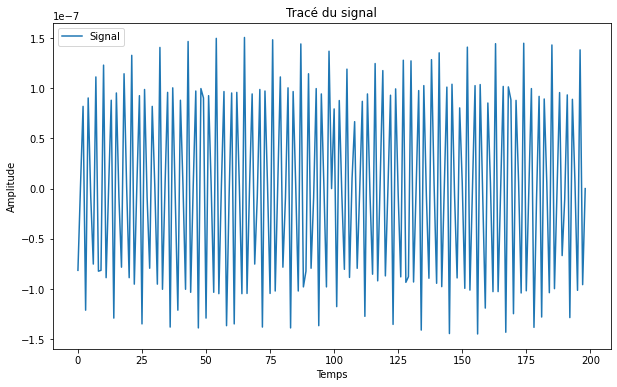

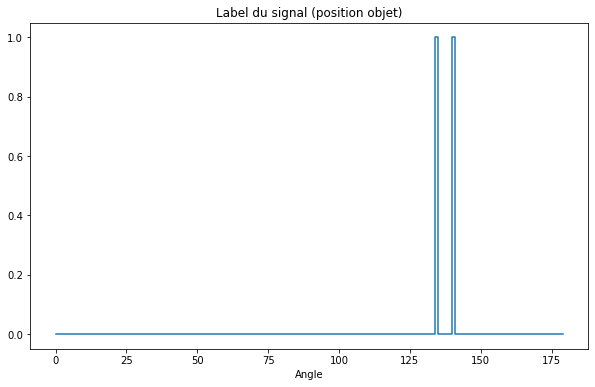

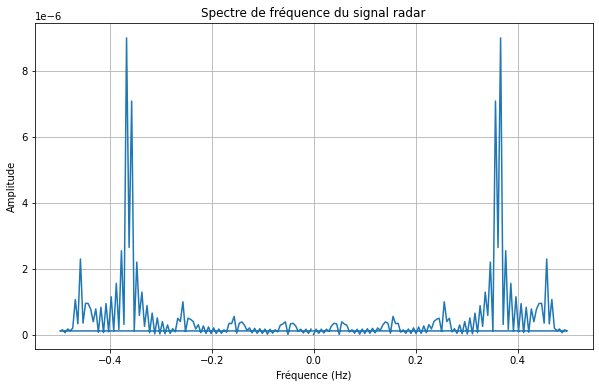

In [6]:
radar_dataset.plot(0) #Plot the first signal

In [7]:
basicNNModel1 = BasicNNModel()
basicNNModel1.load("basicNNModel1")

basicNNModel2 = BasicNNModel()
basicNNModel2.load("basicNNModel2")

basicCNNModel1 = BasicNNModel()
basicCNNModel1.load("basicCNNModel1")

basicAutoEncoder = BasicAutoEncoder()
basicAutoEncoder.load("basicAutoEncoder")
X_test_encoded = basicAutoEncoder.encode(radar_dataset.X_test).squeeze()

C:\Users\HP\anaconda3\lib\site-packages\keras\saving\legacy\saved_model\load.py:110: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  metadata.ParseFromString(file_content)


AttributeError: '_UserObject' object has no attribute 'predict'

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

In [10]:

radar_dataset.X_train, radar_dataset.X_test, radar_dataset.y_train, radar_dataset.y_test = train_test_split(radar_dataset.X, radar_dataset.y, test_size=0.2, random_state=42)

In [62]:
rnn=Sequential()
rnn.add(SimpleRNN(units=32, return_sequences=True,input_shape=(radar_dataset.X_train.shape[1],1)))
rnn.add(SimpleRNN(units=32, return_sequences=True))
rnn.add(SimpleRNN(units=32, return_sequences=True))
rnn.add(SimpleRNN(units=32))
rnn.add(Dense(units=1))

In [18]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 199, 32)           1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 199, 32)           2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 199, 32)           2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [21]:
#TODO
#Compile SimpleRNN model (Adam optimizer, Mean_squared_error loss) 
rnn.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=40)

In [31]:
rnn.compile(optimizer='adam', loss='mean_squared_error')
rnn_history=rnn.fit(radar_dataset.X_train, radar_dataset.y_train, batch_size=10, epochs=30, validation_data=(radar_dataset.X_test, radar_dataset.y_test), callbacks=[early_stop])

Epoch 1/30
248/248 [==============================] - 23s 82ms/step - loss: 0.0129 - val_loss: 0.0105
Epoch 2/30
248/248 [==============================] - 20s 82ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 3/30
248/248 [==============================] - 20s 82ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 4/30
248/248 [==============================] - 21s 84ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 5/30
248/248 [==============================] - 20s 79ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 6/30
248/248 [==============================] - 20s 80ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 7/30
248/248 [==============================] - 20s 81ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 8/30
248/248 [==============================] - 20s 82ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 9/30
248/248 [==============================] - 20s 81ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 10/30
248/248 [==============================] - 20s 79ms/step - loss: 0.010

IndexError: list index out of range

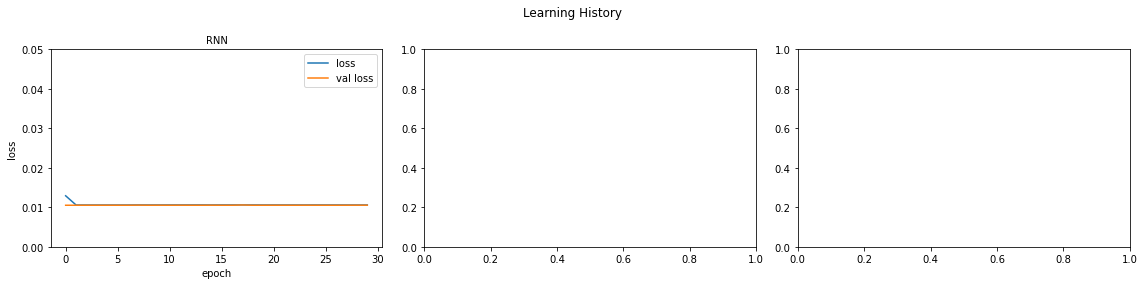

In [32]:

titles = ['RNN']

# Create a list of prediction models
models = [rnn_history]

# Set the plot area
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)  

# Plot learning history
plt.suptitle('Learning History')
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i], fontsize=10) 
    plt.plot(models[i].history['loss'], label='loss')
    plt.plot(models[i].history['val_loss'], label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.ylim([0,0.05])

In [42]:
from sklearn.preprocessing import MinMaxScaler
#Scale the data to make it applicable for RNN
scaler=MinMaxScaler(feature_range=(0,1))
radar_dataset_scaled=scaler.fit_transform(labels)
radar_dataset_scaled[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

In [65]:
scaler = MinMaxScaler()
scaler.fit(radar_dataset.X_train)

# Use the same scaler to scale your test data
X_test_scaled = scaler.transform(radar_dataset.X_test)

# Make predictions
rnn_y_pred = rnn.predict(X_test_scaled)
rnn_y_pred_reshaped = np.repeat(rnn_y_pred, 199, axis=1)

# Inverse transform the predictions to the original scale
rnn_y_pred = scaler.inverse_transform(rnn_y_pred_reshaped)

20/20 [==============================] - 0s 20ms/step


In [72]:
rnn_y_pred.shape

array_199 = rnn_y_pred  # Replace with your actual data

# Desired shape
desired_shape = (620, 180)

# Check if the shape of the array needs adjustment
if array_199.shape != desired_shape:
    if array_199.shape[1] > desired_shape[1]:
        # If the original shape has more columns than desired, crop the array
        array_180 = array_199[:, :desired_shape[1]]
    else:
        # If the original shape has fewer columns, you might need to pad it with zeros
        # Here, it pads on the right side
        pad_width = ((0, 0), (0, desired_shape[1] - array_199.shape[1]))
        array_180 = np.pad(array_199, pad_width, mode='constant')
else:
    array_180 = array_199  # No adjustment needed

In [74]:
from sklearn.metrics import mean_squared_error
true_labels = radar_dataset.y_test  # Replace with your true target values
rnn_predictions = array_180  # Replace with your RNN predictions

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, rnn_predictions)

# Print the MSE
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.08023768912111418


In [80]:
rmse = np.sqrt(mse)
print(f"Mean Squared Error (rMSE): {rmse}")

Mean Squared Error (rMSE): 0.28326257981087827


In [81]:
from sklearn.metrics import r2_score
r2 = r2_score(true_labels, rnn_predictions)
print(f"Mean Squared Error (r2): {r2}")

Mean Squared Error (r2): -3.1363013401278685


IndexError: list index out of range

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


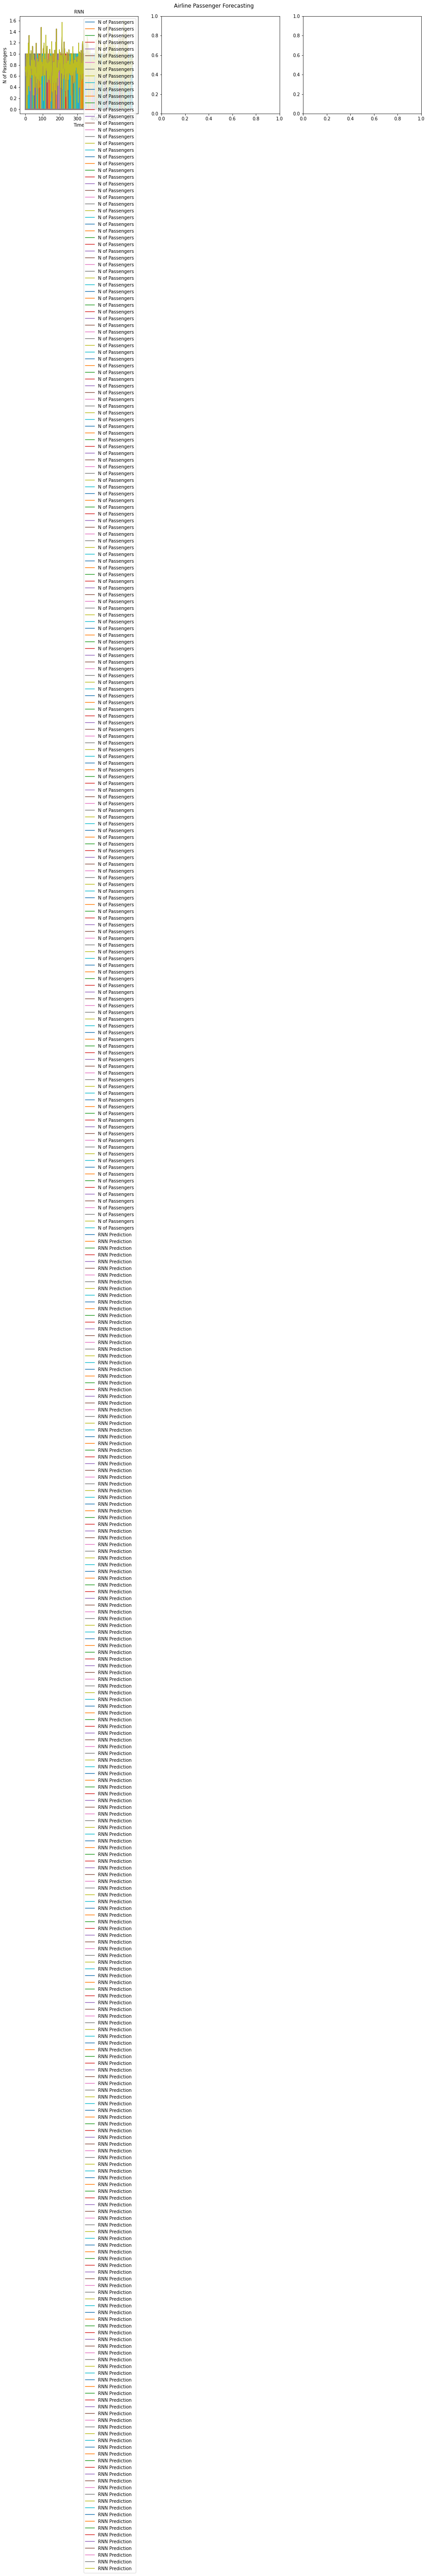

In [54]:
# Visualize Prediction Results

# Set subplot subtitles
titles = ['RNN']

# Create a list of prediction models
models = [rnn_y_pred]

# Set the plot area
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)  

# Set the title
plt.suptitle('Airline Passenger Forecasting')

# Create and show subplots
for i in range(0, 3):
    plt.subplot(1, 3,i+1)
    plt.title(titles[i], fontsize=10) 
    plt.plot(radar_dataset.y_test, label='N of Passengers')
    plt.plot(models[i], label=titles[i]+' Prediction')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N of Passengers') 

In [ ]:

polynomialRegressor = PolynomialRegressor()
polynomialRegressor.train(abs(radar_dataset.X_freq_train),radar_dataset.y_train)



In [ ]:
polynomialRegressor.evaluate(abs(radar_dataset.X_freq_test),radar_dataset.y_test)